## 1. Download video

In [6]:
import requests
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

dropbox: https://www.dropbox.com/home/Face%20Tracking%20Project

In [1]:
vidname = "vid2"
url = "https://www.dropbox.com/scl/fi/ui991ev1h9rnexhr3onvl/vid2.mp4?rlkey=a6l2rkt55oonmkni7qdkeq0gj&st=tso0c7tf&dl=1"

In [ ]:
# # Dropbox shared link (change dl=0 → dl=1 for direct download)
# output_path = f"{vidname}.mp4"

# # Download file
# response = requests.get(url, stream=True)
# response.raise_for_status()  # Check for download errors

# # Save to local file
# with open(output_path, "wb") as f:
#     for chunk in response.iter_content(chunk_size=8192):
#         if chunk:
#             f.write(chunk)

# print(f"✅ Download completed: {output_path}")

✅ Download completed: vid2.mp4


## 2. Run test Request

### 2a. Test face extract

In [2]:
import requests

url = "http://127.0.0.1:8000/capture_faces"
file_path = rf"/home/bngl1/projects/cs5939/{vidname}.mp4"

with open(file_path, "rb") as f:
    files = {"video": (rf"{vidname}.mp4", f, "video/mp4")}
    response = requests.post(url, files=files)
    
print("Status Code:", response.status_code)
print("Response:", response.json())

# docker run -d --name face-api -p 8000:8000 --env-file .env face-extract-api

Status Code: 200
Response: {'status': 'success', 'message': 'Processed vid2.mp4', 'saved_dir': 'face_image'}


### 2b. Test face encode 

In [18]:
import requests
import os

url = "http://10.0.0.2:8001/encode"
file_path = "/home/bngl1/projects/cs5939/sample_frame.jpg"

filename = os.path.basename(file_path)

print(filename)

with open(file_path, "rb") as f:
    files = {"file": (filename, f, "image/jpeg")}
    response = requests.post(url, files=files)

print("Status code:", response.status_code)
print("Response:", response.text)


sample_frame.jpg


Status code: 200
Response: {"status":"embedding created","file":"sample_frame.jpg","vector_path":"/app/embeddings/sample_frame.npy","image_path":"/app/face_images/sample_frame.jpg"}


### 2c. Test face analysis

In [4]:
import requests

url = "http://10.0.0.2:8002/cluster_video_faces"
params = {
    "video_name": vidname,
    "threshold": 0.3
}

response = requests.get(url, params=params)

print(response.status_code)
response.json()


200


{'video_name': 'vid2',
 'threshold': 0.3,
 'num_persons': 1,
 'groups': [{'person_id': 1,
   'faces': [{'name': 'vid2_img0',
     'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAE2ATYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDnpW87V7mYch5ODmtFTtQet

Status Code: 200
✅ Found 1 person(s) in 'vid2' with threshold=0.3

Person 1: vid2_img0, vid2_img1, vid2_img2, vid2_img3


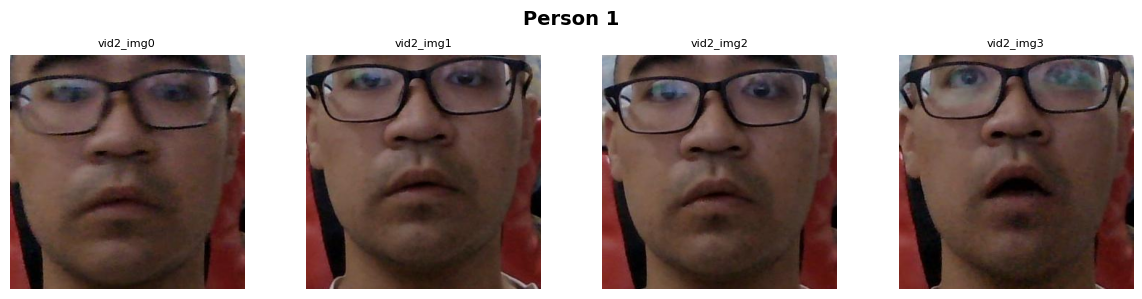

In [7]:
def cluster_and_show_faces(video_name="vid4", threshold=0.3):
    url = "http://10.0.0.2:8002/cluster_video_faces"
    params = {"video_name": video_name, "threshold": threshold}

    response = requests.get(url, params=params)
    print(f"Status Code: {response.status_code}")

    if response.status_code != 200:
        print(f"❌ Error: {response.text}")
        return

    data = response.json()

    # Print summary header
    print(f"✅ Found {data['num_persons']} person(s) in '{video_name}' with threshold={threshold}\n")

    for i, group in enumerate(data["groups"], 1):
        face_names = [face["name"] for face in group["faces"]]
        print(f"Person {i}: {', '.join(face_names)}")

        # Create subplot for this person
        n = len(face_names)
        fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))
        if n == 1:
            axes = [axes]

        for j, face in enumerate(group["faces"]):
            name = face["name"]
            img_base64 = face["image_base64"]

            if img_base64:
                # Decode base64 to PIL Image
                img_bytes = base64.b64decode(img_base64)
                img = Image.open(BytesIO(img_bytes))

                # Display image with title
                axes[j].imshow(img)
                axes[j].set_title(name, fontsize=8)
                axes[j].axis('off')
            else:
                axes[j].text(0.5, 0.5, "Missing", ha='center', va='center', fontsize=8)
                axes[j].axis('off')

        # Add big title above all images
        fig.suptitle(f"Person {i}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Run it!
cluster_and_show_faces(vidname)

## 3. Read logs

In [3]:
import subprocess
import re

def get_recent_docker_logs_simple(container_name, time_ago="3m"):
    """
    Get recent Docker logs and remove unwanted lines like GET /metrics.
    time_ago examples: "3m" (3 minutes), "5s" (5 seconds), "1h" (1 hour)
    """
    try:
        result = subprocess.run(
            ['docker', 'logs', '--since', time_ago, container_name],
            capture_output=True,
            text=True,
            check=True
        )
        logs = result.stdout

        # Filter out lines that match unwanted patterns
        filtered_lines = []
        for line in logs.splitlines():
            if re.search(r'GET /metrics', line):
                continue  # skip metrics logs
            filtered_lines.append(line)

        return "\n".join(filtered_lines)

    except subprocess.CalledProcessError as e:
        print(f"Error getting logs: {e}")
        return None


# === Example usage ===
recent_logs = get_recent_docker_logs_simple('face-api', "1m")
if recent_logs:
    print(recent_logs)

    # Write filtered logs to file
    with open('/home/bngl1/projects/cs5939/container_output/face-api-recent.log', 'w') as f:
        f.write(recent_logs)


[2025-11-15 13:12:08] 📂 Temp video path: /app/uploaded_videos/vid2.mp4
[2025-11-15 13:12:08] ✅ Uploaded video saved: vid2.mp4
[2025-11-15 13:12:08] 🎬 Starting face capture for vid2.mp4
[2025-11-15 13:12:09] 📸 Saved after 1.25s stable: /app/face_image/vid2_img0.jpg
[2025-11-15 13:12:09] ✅ Sent vid2_img0.jpg to encoder: 200
[2025-11-15 13:12:09] 📸 Saved after 1.25s stable: /app/face_image/vid2_img1.jpg
[2025-11-15 13:12:09] ✅ Sent vid2_img1.jpg to encoder: 200
[2025-11-15 13:12:10] 📸 Saved after 1.25s stable: /app/face_image/vid2_img2.jpg
[2025-11-15 13:12:10] ✅ Sent vid2_img2.jpg to encoder: 200
[2025-11-15 13:12:11] 📸 Saved after 1.25s stable: /app/face_image/vid2_img3.jpg
[2025-11-15 13:12:11] ✅ Sent vid2_img3.jpg to encoder: 200
End of video or failed to read frame.
[2025-11-15 13:12:11] ✅ Finished processing: vid2.mp4
[2025-11-15 13:12:11] 🗑️ Temp file removed: /app/uploaded_videos/vid2.mp4
INFO:     138.251.13.176:51034 - "POST /capture_faces HTTP/1.1" 200 OK
